In [30]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [ ]:
# URL of the page to scrape
url = "https://www.cagematch.net/?id=8&nr=1&page=8"

# Send a GET request to fetch the page's HTML content
response = requests.get(url)
if response.status_code != 200:
    print(f"Failed to fetch page: {response.status_code}")
else:
    print("Page fetched successfully!")
    
# Parse the HTML content with BeautifulSoup
soup = BeautifulSoup(response.text, 'html.parser')

# Find all <div> elements with class 'QuickResultsHeader'
headers = soup.find_all('div', {'class': 'QuickResultsHeader'})

# Extract the text content of each header
results = []
for header in headers:
    results.append(header.text.strip())

# Display the extracted data
for result in results:
    print(result)

Page fetched successfully!
(29.04.2025) WWE NXT #783 - TV-Show @ WWE Performance Center in Orlando, Florida, USA
(28.04.2025) WWE Main Event #657 - Online Stream @ T-Mobile Center in Kansas City, Missouri, USA
(28.04.2025) WWE Monday Night RAW #1666 - Online Stream @ T-Mobile Center in Kansas City, Missouri, USA
(27.04.2025) WWE LFG: Legends & Future Greats #1.11 - The Name Says It All - TV-Show @ WWE Performance Center in Orlando, Florida, USA
(27.04.2025) WWE LFG: Legends & Future Greats #1.10 - Expect The Unexpected - TV-Show @ WWE Performance Center in Orlando, Florida, USA
(26.04.2025) WWE NXT Live - House Show @ Engelwood Neighborhood Center in Orlando, Florida, USA
(25.04.2025) WWE NXT Live - House Show @ Dade City Armory in Dade City, Florida, USA
(25.04.2025) WWE Speed #70 - Online Stream @ Dickies Arena in Fort Worth, Texas, USA
(25.04.2025) WWE Friday Night SmackDown #1340 - TV-Show @ Dickies Arena in Fort Worth, Texas, USA
(22.04.2025) WWE NXT #782 - TV-Show @ BleauLive The

In [48]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re

# Initialize a list to store match data
matches = []


base_url = "https://www.cagematch.net/?id=8&nr=1&page=8"

# Loop through offsets from 0 to 1000, incrementing by 100
for offset in range(0, 300, 100):  # Offset stops at 1000 -- full site is 27001
    url = f"{base_url}&s={offset}" if offset > 0 else base_url
    print(f"Scraping URL: {url}")
    
    
    # Send a GET request
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed to fetch page: {response.status_code}")
        continue
    
    # Parse the HTML content with BeautifulSoup
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Find all <div> elements representing match sections
    match_sections = soup.find_all('div', class_='QuickResultsHeader')

    # Function to extract match time robustly
    def extract_match_time(match_results_text):
        """
        Extract match time, even if it appears after (c) and before TITLE CHANGE.
        Example:
            "Giulia defeats Roxanne Perez (c) (11:14) - TITLE CHANGE !!!" -> "11:14"
        """
        time_match = re.search(r'\((\d{1,2}:\d{2})\)(?:\s+-\s+TITLE CHANGE !!!)?', match_results_text)
        if time_match:
            return time_match.group(1)
        return None

    # Loop through each match section
    for section in match_sections:
        # Skip if "House Show" or "LFG" is mentioned in the section header (case-insensitive)
        if re.search(r'\b(house show|lfg)\b', section.get_text(strip=True), re.IGNORECASE):
            continue  # Skip House Show or LFG sections entirely

        # Find all <li> elements (each represents a match) within this section
        match_elements = section.find_next_sibling('ul').find_all('li') if section.find_next_sibling('ul') else []

        for match in match_elements:
            # Extract match type from <span class="MatchType">
            match_type_elem = match.find('span', class_='MatchType')
            match_type = match_type_elem.get_text(separator=' ', strip=True) if match_type_elem else None
            
            # Skip if Match Type contains "Dark" (case-insensitive, handles complex structures)
            if match_type and re.search(r'\bdark\b', match_type, re.IGNORECASE):
                continue  # Skip Dark matches
            
            match_type = re.sub(r':$', '', match_type) if match_type else None

            # Extract match results from <span class="MatchResults">
            match_results_elem = match.find('span', class_='MatchResults')
            if match_results_elem:
                # Extract time robustly
                match_time = extract_match_time(match_results_elem.text)

                # Remove time, (c), and TITLE CHANGE from the match results text
                match_results_text = re.sub(r'\(c\)', '', match_results_elem.text)
                match_results_text = re.sub(r'\s*\(\d{1,2}:\d{2}\)(?:\s+-\s+TITLE CHANGE !!!)?', '', match_results_text).strip()

                # Determine the match finish
                lower_results = match_results_text.lower()
                finish = 'pinfall'
                if 'by dq' in lower_results:
                    finish = 'DQ'
                elif 'by count out' in lower_results or 'by countout' in lower_results:
                    finish = 'countout'
                elif 'by submission' in lower_results:
                    finish = 'submission'
                elif 'by no contest' in lower_results:
                    finish = 'no contest'
                elif 'double count out' in lower_results:
                    finish = 'double count out'

                results_split = re.split(r' defeat[s]? ', match_results_elem.text, maxsplit=1)

                if len(results_split) == 2:
                    winners_section = results_split[0]
                    losers_section = results_split[1]

                    # Clean names
                    winners_section = re.sub(r'\(c\)', '', winners_section)
                    losers_section = re.sub(r'\(c\)', '', losers_section)

                    winners_section = re.sub(r'\(w/.*\)', '', winners_section)
                    losers_section = re.sub(r'\(w/.*\)', '', losers_section)

                    winners_section = re.sub(r'\(\d{1,2}:\d{2}\)', '', winners_section)
                    losers_section = re.sub(r'\(\d{1,2}:\d{2}\)', '', losers_section)

                    winners_section = re.sub(r'\s+-\s*$', '', winners_section)
                    losers_section = re.sub(r'\s+-\s*$', '', losers_section)

                    losers_section = re.sub(r'\s+by\s+\w+.*$', '', losers_section).strip()

                    title_change = False
                    if 'TITLE CHANGE !!!' in losers_section:
                        title_change = True
                        losers_section = re.sub(r'TITLE CHANGE !!!', '', losers_section).strip()

                    # Replace '&' and 'and' with ', '
                    def replace_and_symbols(name):
                        name = name.replace(" & ", ", ")
                        name = name.replace(" and ", ", ")
                        return name.strip(", ")

                    winners_section = replace_and_symbols(winners_section)
                    losers_section = replace_and_symbols(losers_section)

                    # Store match data
                    matches.append({
                        'Match Type': match_type,
                        'Winners': winners_section,
                        'Losers': losers_section,
                        'Time': match_time,
                        'Finish': finish,
                        'Title Change': title_change
                    })

# Convert matches to a DataFrame
df = pd.DataFrame(matches)
df



Scraping URL: https://www.cagematch.net/?id=8&nr=1&page=8
Scraping URL: https://www.cagematch.net/?id=8&nr=1&page=8&s=100
Scraping URL: https://www.cagematch.net/?id=8&nr=1&page=8&s=200


,Match Type,Winners,Losers,Time,Finish,Title Change
0,WWE NXT North American Title,Ricky Saints,Lexis King,8:25,pinfall,False
1,None,Sol Ruca,Karmen Petrovic,3:28,pinfall,False
2,WWE NXT Tag Team Title,"Hank And Tank (Hank Walker, Tank Ledger)","Josh Briggs, Yoshiki Inamura",10:29,pinfall,False
3,None,"IYO SKY, Jordynne Grace","Giulia, Roxanne Perez",14:25,pinfall,False
4,None,Dragon Lee,Karrion Kross,None,pinfall,False
...,...,...,...,...,...,...
780,None,Uncle Howdy,Chad Gable,13:58,pinfall,False
781,None,Lyra Valkyria,Izzi Dame,5:59,pinfall,False
782,None,"The Authors Of Pain (Akam, Rezar)","Alpha Academy (Akira Tozawa, Otis)",6:45,pinfall,False
783,WWE Women's Speed Title Tournament First Round,IYO SKY,Lyra Valkyria,2:18,pinfall,False


In [33]:
import re
from bs4 import BeautifulSoup

# Example HTML snippet
html = '''
<li>
  <span class="MatchType">Dark <a href="?id=5&amp;nr=20">WWE Title</a> / <a href="?id=5&amp;nr=3102">WWE Universal Title</a>:</span>
  <span class="MatchResults">
    <a href="?id=2&amp;nr=3686&amp;name=Cody+Rhodes">Cody Rhodes</a> (c) defeats 
    <a href="?id=2&amp;nr=15859&amp;name=Carmelo+Hayes">Carmelo Hayes</a>
  </span>
</li>
'''

# Parse the HTML
soup = BeautifulSoup(html, 'html.parser')

# Extract MatchType
match_type_elem = soup.find('span', class_='MatchType')

# Debug Step 1: Show the raw extracted MatchType element
print("RAW MatchType Element:", match_type_elem)

# Get text, preserving spaces for debugging
match_type_text = match_type_elem.get_text(separator=' ', strip=True) if match_type_elem else ''

# Debug Step 2: Show the extracted text
print("Extracted MatchType Text:", repr(match_type_text))

# Check for 'Dark'
def is_dark_match(match_type_text):
    """
    Determines if 'Dark' exists in the MatchType text after parsing.
    """
    debug_result = re.search(r'\bdark\b', match_type_text, re.IGNORECASE)
    print("Regex Match Object:", debug_result)
    return bool(debug_result)

# Run the function and print the result
result = is_dark_match(match_type_text)
print("Contains 'Dark':", result)


RAW MatchType Element: <span class="MatchType">Dark <a href="?id=5&amp;nr=20">WWE Title</a> / <a href="?id=5&amp;nr=3102">WWE Universal Title</a>:</span>
Extracted MatchType Text: 'Dark WWE Title / WWE Universal Title :'
Regex Match Object: <re.Match object; span=(0, 4), match='Dark'>
Contains 'Dark': True


In [34]:
import pandas as pd
import re

def split_tag_teams_from_columns(df, winners_col='Winners', losers_col='Losers'):
    """
    Splits tag teams into individual names in specified Winners and Losers columns of an existing DataFrame.
    Example: "#DIY (Johnny Gargano, Tommaso Ciampa)" -> "Johnny Gargano, Tommaso Ciampa"
    
    Args:
        df (pd.DataFrame): The DataFrame to process.
        winners_col (str): Name of the column containing Winners.
        losers_col (str): Name of the column containing Losers.
    
    Returns:
        pd.DataFrame: DataFrame with updated Winners and Losers columns.
    """
    def split_tag_teams(value):
        if pd.isna(value):  # Handle NaN values
            return value
        
        # Match content inside parentheses
        pattern = r'\((.*?)\)'
        matches = re.findall(pattern, value)
        
        individuals = []  # Store individual names
        
        if matches:
            for match in matches:
                # Split the matched content by comma and add each member
                individuals.extend([member.strip() for member in match.split(',')])
        
        # Remove the tag team names and return only the extracted names
        return ', '.join(individuals) if individuals else value
    
    # Apply the function to Winners and Losers columns
    if winners_col in df.columns:
        df[winners_col] = df[winners_col].apply(split_tag_teams)
    if losers_col in df.columns:
        df[losers_col] = df[losers_col].apply(split_tag_teams)
    
    return df

split_tag_teams_from_columns(df)




,Match Type,Winners,Losers,Time,Finish,Title Change
0,WWE NXT North American Title,Ricky Saints,Lexis King,8:25,pinfall,False
1,None,Sol Ruca,Karmen Petrovic,3:28,pinfall,False
2,WWE NXT Tag Team Title,"Hank Walker, Tank Ledger","Josh Briggs, Yoshiki Inamura",10:29,pinfall,False
3,None,"IYO SKY, Jordynne Grace","Giulia, Roxanne Perez",14:25,pinfall,False
4,None,Dragon Lee,Karrion Kross,None,pinfall,False
...,...,...,...,...,...,...
780,None,Uncle Howdy,Chad Gable,13:58,pinfall,False
781,None,Lyra Valkyria,Izzi Dame,5:59,pinfall,False
782,None,"Akam, Rezar","Akira Tozawa, Otis",6:45,pinfall,False
783,WWE Women's Speed Title Tournament First Round,IYO SKY,Lyra Valkyria,2:18,pinfall,False


In [35]:
import re

# Function to clean text in Winners and Losers columns
def clean_column(value):
    if pd.isna(value):  # Handle NaN values
        return value
    
    # Remove any bracketed content like [2:0], [Runde 3]
    value = re.sub(r'\[.*?\]', '', value)
    
    # Remove trailing dashes and extra spaces
    value = re.sub(r'\s*-\s*$', '', value)
    
    # Strip extra whitespace
    return value.strip()

# Apply the cleaning function to both columns
df['Winners'] = df['Winners'].apply(clean_column)
df['Losers'] = df['Losers'].apply(clean_column)



In [45]:
# Enhanced logic to identify Multi-Man matches
def is_multi_man(row):
    match_type = str(row['Match Type']).lower()
    losers = str(row.get('Losers', '')).split(',')
    winners = str(row.get('Winners', '')).split(',')

    # Check for specific keywords in the match type
    if any(kw in match_type for kw in ['fatal four way', 'triple threat', 'gauntlet', 'battle royal', 'ten man']):
        return 'Multi-Man'
    # Check if there is one winner and multiple losers
    elif len(winners) == 1 and len(losers) > 1:
        return 'Multi-Man'
    else:
        return None

# Apply the updated logic to create the Multi-Man column
df['Multi-Man'] = df.apply(is_multi_man, axis=1)

# Expanded list of stipulations
stipulation_keywords = [
    'hardcore', 'casket', 'ambulance', 'anything goes', 'sudden death',
    'tables', 'devil\'s playground', 'ladder', 'chair', 'chairs', 'bull rope',
    'strap', 'kendo stick', 'singapore cane', 'steel cage', 'no holds barred',
    'hell in a cell', 'street fight', 'falls count anywhere', 'last man standing',
    'i quit', 'submission', 'buried alive', 'inferno', 'punjabi prison',
    'blindfold', 'lumberjack', 'tribal combat', 'second city strap',
    'elimination chamber', 'tower of doom', 'beat the clock', 'three stages of hell',
    'survivors match', 'iron man', 'texas death', 'extreme rules',
    'best two out of three falls', 'death', 'double dog collar', 'pure rules',
    'new japan rambo', 'wargames', 'barbed wire board'
]

# Add a new Stipulation column
df['Stipulation'] = df['Match Type'].apply(
    lambda x: 'Stipulation' if any(kw in str(x).lower() for kw in stipulation_keywords) else None
)

# Update Category column logic
def classify_match_type(match_type):
    match_type = str(match_type).lower()
    if ('#1 contendership' in match_type and 'final' in match_type) or ('#1 contendership' in match_type and 'tournament' not in match_type):
        return '#1 Contendership'
    elif 'title' in match_type and not any(kw in match_type for kw in ['semi final', 'tournament first round']):
        return 'Title'
    elif 'battle royal' in match_type:
        return 'Battle Royal'
    else:
        return None

# Apply the classification logic
df['Category'] = df['Match Type'].apply(classify_match_type)

# Ensure Tornado Tag is excluded from Multi-Man
df.loc[df['Match Type'].str.contains('tornado tag', case=False, na=False), 'Multi-Man'] = None

# Display results with Match Type, Category, Multi-Man, and Stipulation
df_subset = df[['Match Type', 'Category', 'Multi-Man', 'Stipulation']]

# Filter and display only rows without Multi-Man matches
df_non_multi_man_only = df[df['Multi-Man'].notnull()]



In [52]:
df_matches[df_matches['Losers'] == 'Karrion Cross']


,Match Type,Winners,Losers,Time,Finish,Title Change,Multi-Man,Stipulation,Category


In [37]:
import pandas as pd

# Initialize ELO ratings
elo_ratings = {}
elo_history = {}

# Helper function to calculate new ELOs
def calculate_elo(winner_elo, loser_avg_elo, k=32):
    expected = 1 / (1 + 10 ** ((loser_avg_elo - winner_elo) / 400))
    elo_change = k * (1 - expected)
    return elo_change

# Update ELO ratings and log history
def update_elo(match_row):
    winners = match_row['Winners'].split(', ')
    losers = match_row['Losers'].split(', ')
    
    # Calculate average ELO of losers
    loser_elos = [elo_ratings.get(loser, 1000) for loser in losers]
    avg_loser_elo = sum(loser_elos) / len(loser_elos)
    
    for winner in winners:
        winner_elo = elo_ratings.get(winner, 1000)
        elo_change = calculate_elo(winner_elo, avg_loser_elo)
        new_elo = winner_elo + elo_change
        
        # Update ELO rating
        elo_ratings[winner] = new_elo
        
        # Log ELO history with Win/Loss
        if winner not in elo_history:
            elo_history[winner] = []
        elo_history[winner].append({
            'Match': match_row['Match Type'],
            'Opponents': ', '.join(losers),
            'ELO Before': winner_elo,
            'ELO Change': elo_change,
            'ELO After': new_elo,
            'Win/Loss': 'Win'
        })
    
    for loser in losers:
        loser_elo = elo_ratings.get(loser, 1000)
        avg_winner_elo = sum([elo_ratings.get(winner, 1000) for winner in winners]) / len(winners)
        elo_change = calculate_elo(loser_elo, avg_winner_elo, k=-32)
        new_elo = loser_elo + elo_change
        
        # Update ELO rating
        elo_ratings[loser] = new_elo
        
        # Log ELO history with Win/Loss
        if loser not in elo_history:
            elo_history[loser] = []
        elo_history[loser].append({
            'Match': match_row['Match Type'],
            'Opponents': ', '.join(winners),
            'ELO Before': loser_elo,
            'ELO Change': elo_change,
            'ELO After': new_elo,
            'Win/Loss': 'Loss'
        })

# Assume df is the DataFrame containing match data
df_matches = df

# Process each match in reverse order
for _, row in df_matches[::-1].iterrows():
    update_elo(row)


# Retrieve ELO history for a specific wrestler with accurate Win/Loss determination
def get_elo_history(wrestler_name):
    if wrestler_name in elo_history:
        # Convert ELO history to DataFrame
        history = pd.DataFrame(elo_history[wrestler_name])
        return history
    else:
        return f"No matches found for {wrestler_name}."

# Example usage
cody_history = get_elo_history('Giulia')
cody_history

,Match,Opponents,ELO Before,ELO Change,ELO After,Win/Loss
0,None,Chelsea Green,1000.000000,16.700912,1016.700912,Win
1,WWE NXT Women's Title,Roxanne Perez,1016.700912,-16.705578,999.995335,Loss
2,None,"Fallon Henley, Jacy Jayne",999.995335,15.559450,1015.554784,Win
3,None,"Cora Jade, Roxanne Perez",1015.554784,16.021246,1031.576030,Win
4,None,"Fallon Henley, Jacy Jayne, Jazmyn Nyx",1031.576030,12.920236,1044.496267,Win
5,None,"Jakara Jackson, Lash Legend",1044.496267,12.898319,1057.394585,Win
6,Iron Survivor Challenge Qualifying,Kelani Jordan,1057.394585,16.093694,1073.488279,Win
7,WWE NXT Women's Title #1 Contendership Iron Su...,"Sol Ruca , Stephanie Vaquer , Wren Sinclair , ...",1073.488279,13.138909,1086.627188,Win
8,None,"Cora Jade, Roxanne Perez",1086.627188,-12.148787,1074.478401,Loss
9,WWE NXT Women's Title,Roxanne Perez,1074.478401,14.131123,1088.609524,Win


In [44]:
# Display current ELO ratings for all wrestlers
elo_df = pd.DataFrame(list(elo_ratings.items()), columns=['Wrestler', 'ELO']).sort_values(by='ELO', ascending=False)
elo_df

df_matches

,Match Type,Winners,Losers,Time,Finish,Title Change,Multi-Man,Stipulation,Category
0,WWE NXT North American Title,Ricky Saints,Lexis King,8:25,pinfall,False,None,None,Title
1,None,Sol Ruca,Karmen Petrovic,3:28,pinfall,False,None,None,None
2,WWE NXT Tag Team Title,"Hank Walker, Tank Ledger","Josh Briggs, Yoshiki Inamura",10:29,pinfall,False,None,None,Title
3,None,"IYO SKY, Jordynne Grace","Giulia, Roxanne Perez",14:25,pinfall,False,None,None,None
4,None,Dragon Lee,Karrion Kross,None,pinfall,False,None,None,None
...,...,...,...,...,...,...,...,...,...
780,None,Uncle Howdy,Chad Gable,13:58,pinfall,False,None,None,None
781,None,Lyra Valkyria,Izzi Dame,5:59,pinfall,False,None,None,None
782,None,"Akam, Rezar","Akira Tozawa, Otis",6:45,pinfall,False,None,None,None
783,WWE Women's Speed Title Tournament First Round,IYO SKY,Lyra Valkyria,2:18,pinfall,False,None,None,None


In [39]:
# Example usage
candice_history = get_elo_history('Chelsea Green')
candice_history

,Match,Opponents,ELO Before,ELO Change,ELO After,Win/Loss
0,None,Michin,1000.000000,15.229860,1015.229860,Win
1,None,Giulia,1015.229860,-16.067744,999.162116,Loss
2,Dumpster,Michin,999.162116,-16.712952,982.449164,Loss
3,WWE Women's United States Title Tournament Fir...,"Bianca Belair, Blair Davenport",982.449164,18.026429,1000.475594,Win
4,WWE Women's Speed Title #1 Contendership Tourn...,Zelina Vega,1000.475594,-16.585114,983.890480,Loss
5,WWE Women's United States Title Tournament Sem...,Bayley,983.890480,20.106780,1003.997259,Win
6,WWE Women's United States Title Tournament Fin...,Michin,1003.997259,18.782900,1022.780159,Win
7,WWE Women's United States Title,Michin,1022.780159,16.976619,1039.756778,Win
8,None,"B-Fab, Michin",1039.756778,-13.903938,1025.852840,Loss
9,WWE Women's United States Title,Michin,1025.852840,-17.407000,1008.445841,Loss


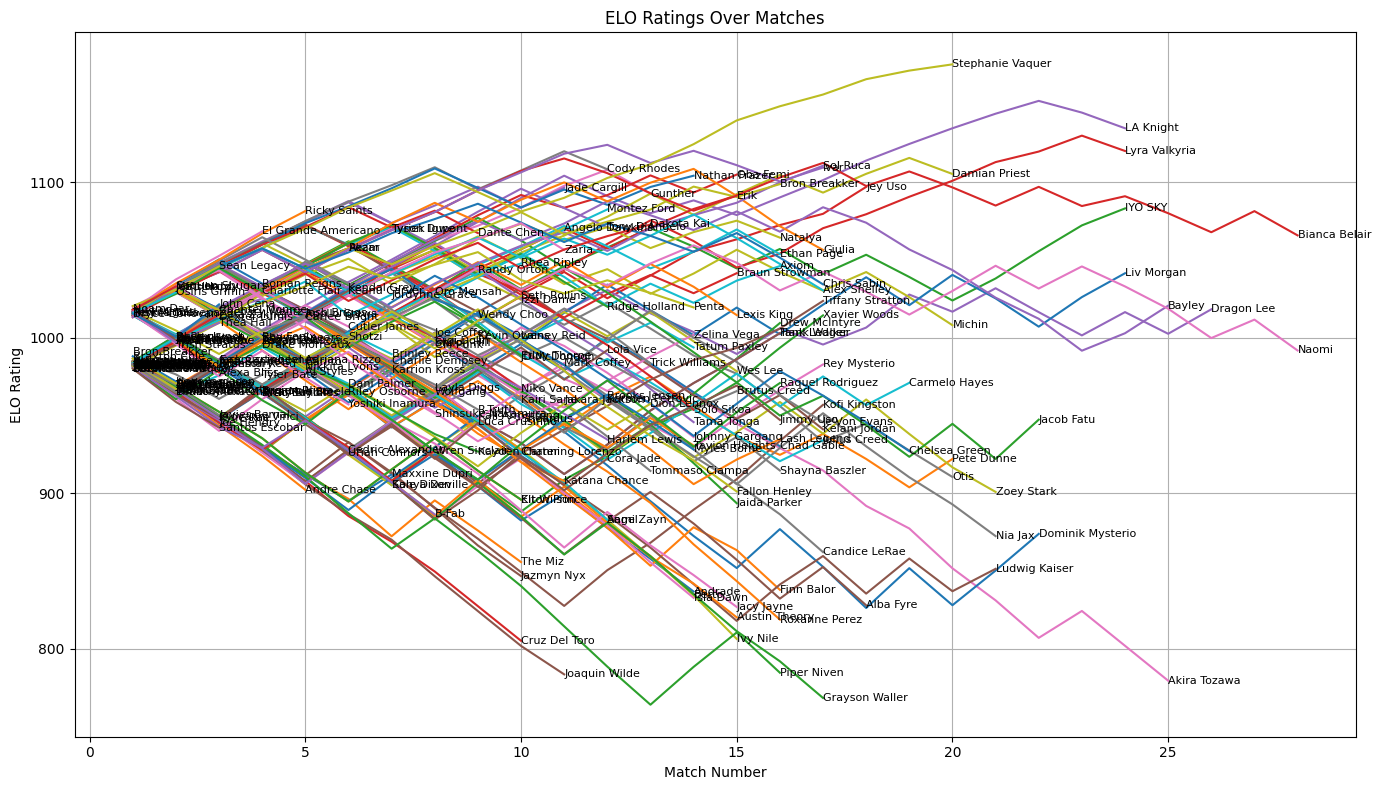

In [40]:
import matplotlib.pyplot as plt

# Create a unified DataFrame from ELO history with match indices
def create_elo_history_df(elo_history):
    records = []
    for wrestler, matches in elo_history.items():
        for i, match in enumerate(matches):
            records.append({
                'Wrestler': wrestler,
                'Match': match['Match'],
                'ELO': match['ELO After'],
                'Match Number': i + 1  # Sequential match number for the wrestler
            })
    return pd.DataFrame(records)

elo_history_df = create_elo_history_df(elo_history)

# Plot ELO changes over matches for all wrestlers
plt.figure(figsize=(14, 8))
for wrestler in elo_history_df['Wrestler'].unique():
    wrestler_data = elo_history_df[elo_history_df['Wrestler'] == wrestler]
    plt.plot(wrestler_data['Match Number'], wrestler_data['ELO'], label=wrestler)
    
    # Annotate at the endpoint of each line
    plt.text(
        x=wrestler_data['Match Number'].iloc[-1],  # Last match number
        y=wrestler_data['ELO'].iloc[-1],          # Last ELO value
        s=wrestler,                               # Wrestler's name
        fontsize=8,                               # Font size
        ha='left',                                # Horizontal alignment
        va='center',                              # Vertical alignment
        color='black'                             # Optional: Match text color with line color
    )

plt.title("ELO Ratings Over Matches")
plt.xlabel("Match Number")
plt.ylabel("ELO Rating")
plt.grid()
plt.tight_layout()
plt.show()


In [41]:
# Example usage
history = get_elo_history('Gunther')
history


,Match,Opponents,ELO Before,ELO Change,ELO After,Win/Loss
0,WWE World Heavyweight Title,Randy Orton,1000.000000,16.000000,1016.000000,Win
1,WWE World Heavyweight Title,Sami Zayn,1016.000000,15.927658,1031.927658,Win
2,None,"Cody Rhodes, Randy Orton",1031.927658,-16.270562,1015.657096,Loss
3,WWE Crown Jewel Title Match (vakant),Cody Rhodes,1015.657096,-18.702012,996.955084,Loss
4,WWE World Heavyweight Title,Damian Priest,996.955084,19.374402,1016.329486,Win
5,None,Dominik Mysterio,1016.329486,14.253562,1030.583048,Win
6,WWE World Heavyweight Title Triple Threat,"Damian Priest, Finn Balor",1030.583048,15.921227,1046.504275,Win
7,WWE World Heavyweight Title,Jey Uso,1046.504275,15.803134,1062.307409,Win
8,None,Akira Tozawa,1062.307409,9.583627,1071.891036,Win
9,None,Otis,1071.891036,11.727573,1083.618609,Win


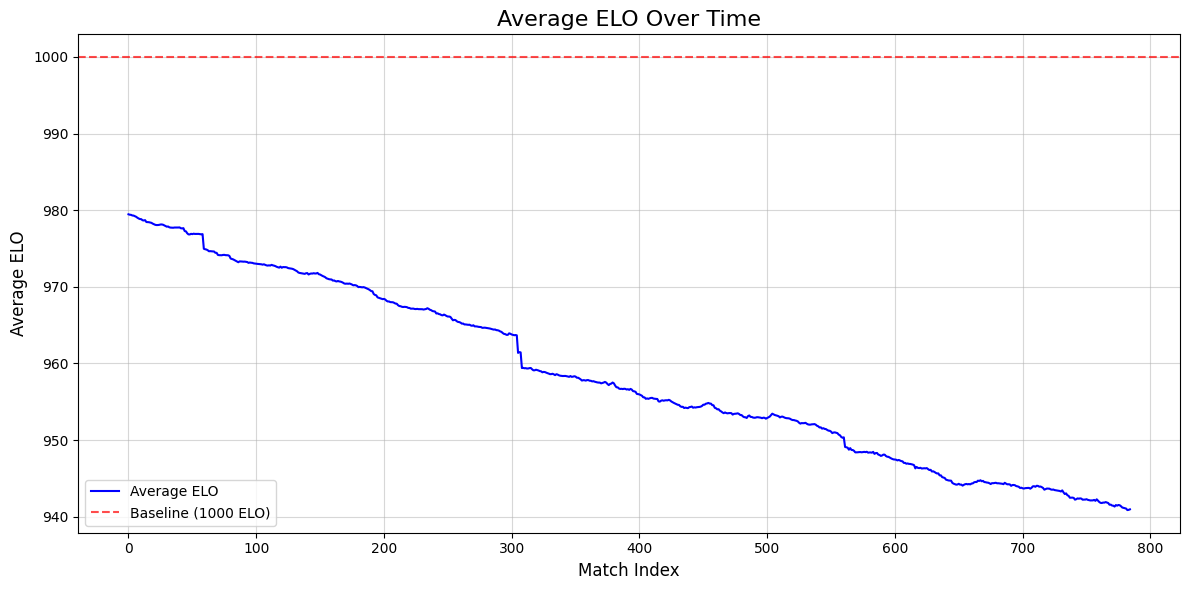

In [42]:
import matplotlib.pyplot as plt
import pandas as pd

# Initialize tracking for average ELO over time
average_elo_over_time = []

# Iterate over matches and update ELOs
for _, row in df_matches.iterrows():
    update_elo(row)  # This function updates ELO ratings for each match
    
    # Calculate the average ELO after processing this match
    average_elo = sum(elo_ratings.values()) / len(elo_ratings)
    average_elo_over_time.append(average_elo)

# Plot the average ELO over time
plt.figure(figsize=(12, 6))
plt.plot(range(len(average_elo_over_time)), average_elo_over_time, label='Average ELO', color='blue')
plt.axhline(y=1000, color='red', linestyle='--', alpha=0.7, label='Baseline (1000 ELO)')
plt.title('Average ELO Over Time', fontsize=16)
plt.xlabel('Match Index', fontsize=12)
plt.ylabel('Average ELO', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()


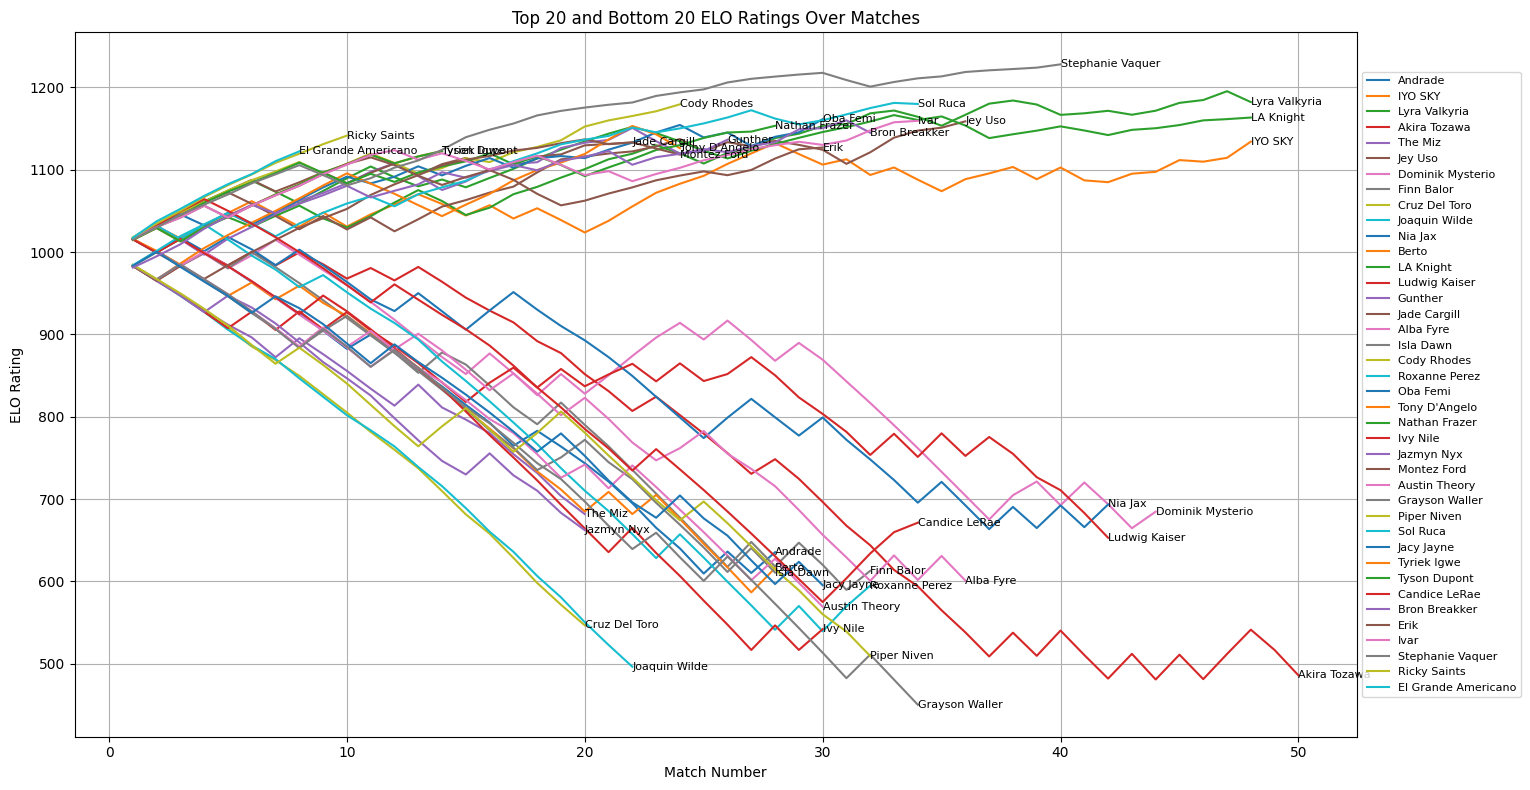

In [43]:
import matplotlib.pyplot as plt

# Create a unified DataFrame from ELO history with match indices
def create_elo_history_df(elo_history):
    records = []
    for wrestler, matches in elo_history.items():
        for i, match in enumerate(matches):
            records.append({
                'Wrestler': wrestler,
                'Match': match['Match'],
                'ELO': match['ELO After'],
                'Match Number': i + 1  # Sequential match number for the wrestler
            })
    return pd.DataFrame(records)

elo_history_df = create_elo_history_df(elo_history)

# Get top 20 and bottom 20 wrestlers by final ELO
final_elos = {wrestler: matches[-1]['ELO After'] for wrestler, matches in elo_history.items()}
sorted_wrestlers = sorted(final_elos.items(), key=lambda x: x[1], reverse=True)
top_20_wrestlers = [w[0] for w in sorted_wrestlers[:20]]
bottom_20_wrestlers = [w[0] for w in sorted_wrestlers[-20:]]

# Filter ELO history DataFrame for these wrestlers
filtered_elo_history_df = elo_history_df[elo_history_df['Wrestler'].isin(top_20_wrestlers + bottom_20_wrestlers)]

# Plot ELO changes over matches for top 20 and bottom 20 wrestlers
plt.figure(figsize=(14, 8))
for wrestler in filtered_elo_history_df['Wrestler'].unique():
    wrestler_data = filtered_elo_history_df[filtered_elo_history_df['Wrestler'] == wrestler]
    plt.plot(wrestler_data['Match Number'], wrestler_data['ELO'], label=wrestler)
    
    # Annotate at the endpoint of each line
    plt.text(
        x=wrestler_data['Match Number'].iloc[-1],  # Last match number
        y=wrestler_data['ELO'].iloc[-1],          # Last ELO value
        s=wrestler,                               # Wrestler's name
        fontsize=8,                               # Font size
        ha='left',                                # Horizontal alignment
        va='center',                              # Vertical alignment
        color='black'                             # Optional: Match text color with line color
    )

plt.title("Top 20 and Bottom 20 ELO Ratings Over Matches")
plt.xlabel("Match Number")
plt.ylabel("ELO Rating")
plt.grid()
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
plt.show()
